In [297]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.optimize as opt
import h5py, glob, re
from scipy.stats import poisson
from scipy.ndimage import gaussian_filter1d

In [150]:
data_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/particle_detectors/sipm_analysis/data/sipm_noise_20240222/"

First find the breakdown voltage from the IV curve:

In [151]:
iv_file = data_path + "20240222_on_semi_sipm_IV.h5"

with h5py.File(iv_file, 'r') as f:
    keys = list(f.keys())
    i_data = np.array(f[keys[0]]['Current'])
    v_data = np.array(f[keys[0]]['Voltage'])

Text(0, 0.5, 'gradient[log(I)]')

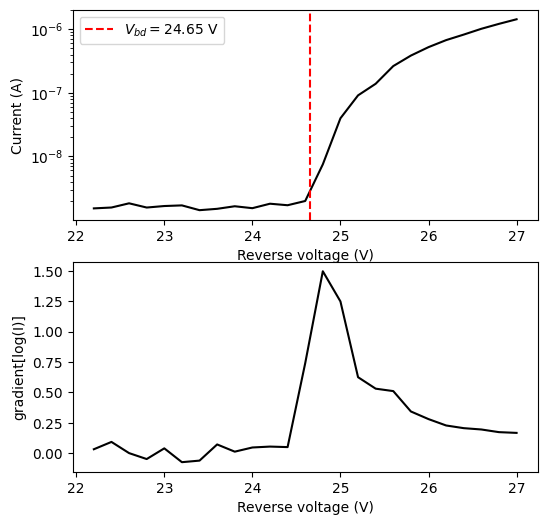

In [152]:
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.semilogy(v_data[1:], np.abs(i_data[1:]), 'k')
yy = plt.ylim()
vbd = 24.65
plt.plot([vbd, vbd], [yy[0], yy[1]], 'r--', label="$V_{bd} = %.2f$ V" % vbd)
plt.xlabel('Reverse voltage (V)')
plt.ylabel('Current (A)')
plt.ylim(yy)
plt.legend()

plt.subplot(2,1,2)
grad = np.gradient(np.log(np.abs(i_data[1:])))
plt.plot(v_data[1:], grad, 'k')
plt.xlabel('Reverse voltage (V)')
plt.ylabel('gradient[log(I)]')

Now let's look at the test pulse data

In [153]:
def assemble_trace_dict(file_list):
    trace_dict = {}

    bias_list = []
    for file_name in file_list:
        match = re.search(r'keithley_([\d.]+)V', file_name)
        number = match.group(1) 
        bias_list.append(float(number))

    for j,f in enumerate(file_list):

        trace_dict[bias_list[j]] = {}

        with h5py.File(f, 'r') as h:
            
            keys = list(h.keys())
            time = h['Time']
            data = h['ch2']
            trig = h['Trigger']
            
            trace_list = list(data.keys())

            trace_dict[bias_list[j]]['time'] = np.array(time)

            trace_array = np.zeros((len(trace_list)-1,len(time)))

            avg_trace = np.zeros(len(time))
            ntraces = len(trace_list)-1
            for tidx, trace in enumerate(trace_list):

                if(tidx==0): continue ## sometimes the first trace is bad

                cdata = np.ndarray.flatten(np.array(data[trace]))
                trace_array[tidx-1, :] = cdata
                avg_trace += cdata

            avg_trace /= ntraces
            trace_dict[bias_list[j]]['traces'] = trace_array
            trace_dict[bias_list[j]]['avg_trace'] = avg_trace

    return trace_dict

In [286]:
def pulse_analysis_bandpass(trace_dict, flo=0.25e6, fhi = 2e6, make_plots=False):

    pulse_heights ={}

    for bias in trace_dict.keys():

        fs = 1/(trace_dict[bias]['time'][1] - trace_dict[bias]['time'][0])
        print(fs)
        nyquist = 0.5*fs
        if(flo>0):
            b, a = sig.butter(1, [flo/nyquist, fhi/nyquist], btype='band')
        else:
            b,a = 0, 0

        traces = trace_dict[bias]['traces']
        ntraces = traces.shape[0]

        max_list = []
        for j in range(ntraces):
            trace = traces[j,:]
            
            if(flo > 0):
                filt_trace = sig.filtfilt(b, a, trace)

                if(make_plots):
                    plt.figure()
                    plt.plot(trace)
                    plt.plot(filt_trace)
                    plt.show()
                    break
            else:
                filt_trace = trace
            max_val = np.max(filt_trace)
            max_list.append(max_val)
        
        pulse_heights[bias] = np.array(max_list)

    return pulse_heights

In [287]:
def gauss_fun(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

In [338]:
def smeared_poisson(x, cal, A, mu, sigma):
    # Generate Poisson distribution
    poisson_dist = poisson(mu)
    int_vals = np.arange(0, np.ceil(x[-1]*cal))
    poisson_pmf = poisson_dist.pmf(int_vals)
    
    # Smear the Poisson distribution with a Gaussian
    smeared_poisson_pmf = np.zeros_like(x)
    for i in range(len(int_vals)):
        smeared_poisson_pmf += A*poisson_pmf[i]*gauss_fun(x, 1, int_vals[i]/cal, sigma/cal)
    
    return smeared_poisson_pmf

In [339]:
test_pulse_file_list = sorted(glob.glob(data_path + "*test_pulse*.h5"))
LED_file_list = sorted(glob.glob(data_path + "*_shape*LED*.h5"))

In [377]:
def plot_resolution(simple_bandpass, do_gauss_fit=False, do_poisson_fit=False, bins_in=[]):

    color_list = ['tab:red','tab:green','tab:blue','tab:purple', 'tab:orange']

    for j,bias in enumerate(simple_bandpass.keys()):

        if(len(bins_in)==0):
            max_amp = np.max(simple_bandpass[bias])*1.2
            bins = np.linspace(0,max_amp,50)
            bc = bins[:-1] + 0.5*np.diff(bins)
        else:
            bins = bins_in

        plt.figure()

        hh, be = np.histogram(simple_bandpass[bias], bins=bins)

        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=color_list[j])

        errs = np.sqrt(hh)
        errs[errs==0] = 1

        if(do_gauss_fit):
            popt, pcov = opt.curve_fit(gauss_fun, bc, hh, p0=[np.max(hh), bc[np.argmax(hh)], 0.01], sigma=errs) 
            xx = np.linspace(bc[0], bc[-1], 1000)
            plt.plot(xx, gauss_fun(xx, *popt), color=color_list[j], label="%.2f V" % bias + ", $\sigma = %.1f$ mV" % (1e3*popt[2])) 

        if(do_poisson_fit):
            nph = 5
            spars = [nph*300/(bias-vbd), np.max(hh), 1]
            smeared_poisson_fixed = lambda x, cal, A, sigma: smeared_poisson(x, cal, A, nph, sigma)
            popt, pcov = opt.curve_fit(smeared_poisson_fixed, bc, hh, p0=spars, sigma=errs) 
            #popt = spars
            xx = np.linspace(bc[0], bc[-1], 1000)
            plt.plot(xx, smeared_poisson_fixed(xx, *popt), color=color_list[j], label="%.2f V" % bias + ", $\sigma = %.1f$ mV" % (1e3*popt[2])) 


    plt.xlabel('Pulse height (V)')
    plt.ylabel('Counts')
    plt.legend()

624999999.999953
624999999.999953
624999999.999953
624999999.999953


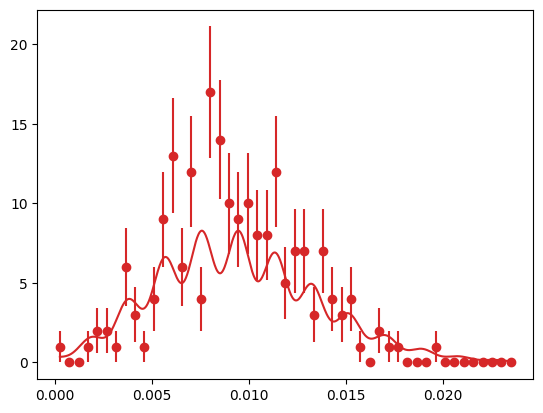

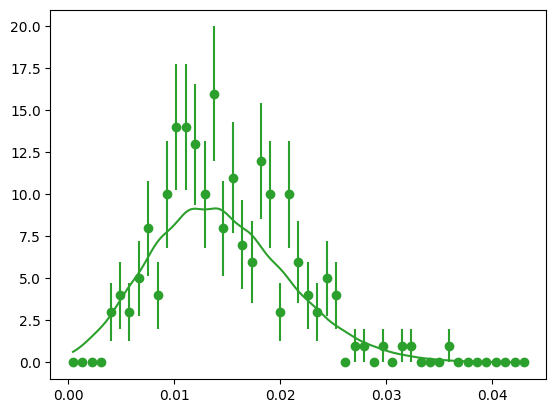

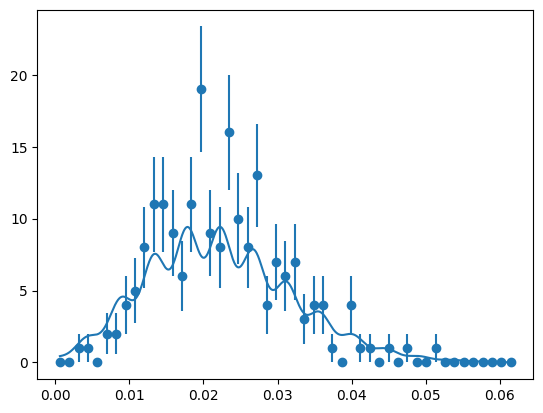

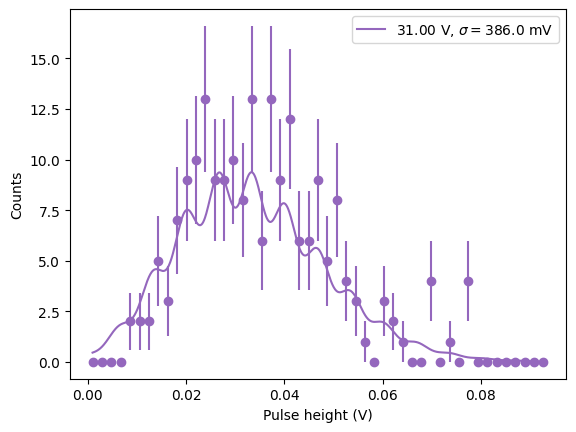

In [378]:
bins = np.linspace(0,0.25,30)

LED_trace_dict = assemble_trace_dict(LED_file_list)
simple_bandpass_LED = pulse_analysis_bandpass(LED_trace_dict, flo=1e4, fhi = 15e5, make_plots=False)
plot_resolution(simple_bandpass_LED, do_gauss_fit=False, do_poisson_fit=True, bins_in=[])

In [326]:
bins = np.linspace(0,0.1,30)
test_pulse_trace_dict = assemble_trace_dict(test_pulse_file_list)
simple_bandpass_test = pulse_analysis_bandpass(test_pulse_trace_dict, flo=-1)
plot_resolution(simple_bandpass_test, bins=bins)

624999999.999953
624999999.999953
624999999.999953
624999999.999953


TypeError: plot_resolution() got an unexpected keyword argument 'bins'

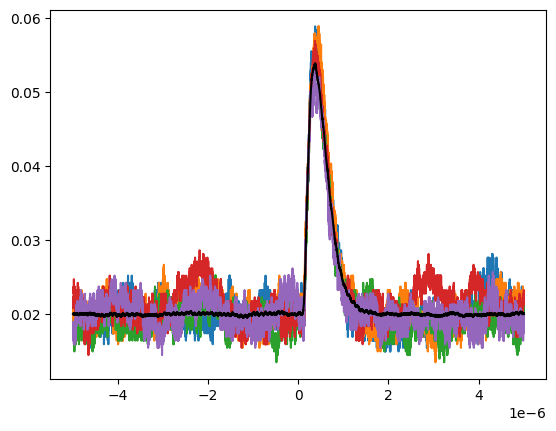

In [131]:
plt.figure()
plt.plot(trace_dict[28.0]['time'], trace_dict[28.0]['traces'][:5,:].T)
plt.plot(trace_dict[28.0]['time'], trace_dict[28.0]['avg_trace'], 'k')